In [53]:
import sys
import gc
from pathlib import Path
sys.path.append('/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/plots')

import lowda
import gc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

In [2]:
del gal
del galiso
gc.collect()

NameError: name 'gal' is not defined

In [54]:
import importlib
importlib.reload(lowda)

<module 'lowda' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/plots/lowda.py'>

In [3]:
lvl = 'lvl4-noB'

In [4]:
name = 'MW4_MHG0.25_GSE2_MHG0.5'
gal = lowda.load_gal(name, lvl, parttype=[0, 2, 4], 
                     fields=None,
                     d_idx=25)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4_MHG0.25_GSE2_MHG0.5  took  00:00:47


In [5]:
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9'
galiso = lowda.load_gal(nameiso, lvl, parttype=[0, 2, 4], 
                        fields=None,
                        d_idx=25)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4iso_fg0.2_MHG0.25_RC9  took  00:00:42


In [59]:
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9'
galisoB = lowda.load_gal(nameiso, 4, parttype=[0, 2, 4], 
                        fields=None,
                        d_idx=25)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4iso_fg0.2_MHG0.25_RC9  took  00:02:08


In [6]:
nameN = 'MW4_MHG0.25_GSE2N'
galN = lowda.load_gal(nameN, lvl, parttype=[0, 2, 4], 
                     fields=None,
                     d_idx=25)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4_MHG0.25_GSE2N  took  00:01:03


In [7]:
namepro = 'MW4_MHG0.25_GSE2_MHG0.5_pro'
galpro = lowda.load_gal(namepro, lvl, parttype=[0, 2, 4], 
                     fields=None,
                     d_idx=25)

loaded up to idx= 1600 time= 8.0
computing COM of idx= 1600
done with MW4_MHG0.25_GSE2_MHG0.5_pro  took  00:01:28


In [ ]:
nameNpro = 'MW4_MHG0.25_GSE2N_pro'
galNpro = lowda.load_gal(nameNpro, lvl, parttype=[0, 2, 4], 
                     fields=None,
                     d_idx=25)

In [ ]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    ElectronAbundance = sn.part0.ElectronAbundance
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [ ]:
def get_cum_mass(gal, rcut, numscalars=4):
    
    CumMass = np.zeros((len(gal['idx_list']), numscalars+1), dtype=float)
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        CumMass[i,0] = sn.Time.value
        
        MW_COM = gal['MW_COM'][i]
        pos = sn.part0.pos.value - MW_COM
        r = np.linalg.norm(pos, axis=1)
        
        if sn.NumPart_Total[4] > 0:
            pos4 = sn.part4.pos.value - MW_COM
            r4 = np.linalg.norm(pos4, axis=1)
        
        for sc in range(numscalars):
            mass = sn.part0.Masses.value * sn.part0.PassiveScalars[:,sc]
            CumMass[i,sc+1] = np.sum(mass[r < rcut])
            
            if sn.NumPart_Total[4] > 0:
                mass = sn.part4.Masses.value * sn.part4.PassiveScalars[:,sc]
                CumMass[i,sc+1] += np.sum(mass[r4 < rcut])

    return CumMass

In [68]:
CumMass = {}
CumMass_iso = {}
CumMass_isoB = {}

rcut_list = np.array([10, 20, 30, 40, 60, 80, 100, 150, 200])
for rcut in tqdm(rcut_list):
    CumMass[rcut] = get_cum_mass(gal, rcut)
    CumMass_iso[rcut] = get_cum_mass(galiso, rcut)
    CumMass_isoB[rcut] = get_cum_mass(galisoB, rcut)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.28s/it]


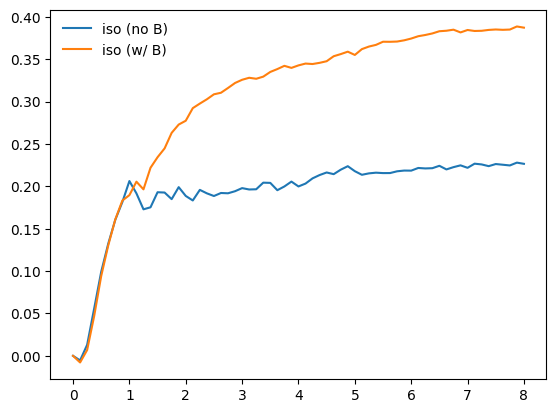

In [75]:
rcut = 10
plt.plot(CumMass_iso[rcut][:,0], CumMass_iso[rcut][:,2] - CumMass_iso[rcut][0,2], label='iso (no B)')
plt.plot(CumMass_isoB[rcut][:,0], CumMass_isoB[rcut][:,2] - CumMass_isoB[rcut][0,2], label='iso (w/ B)')
plt.legend(frameon=False)

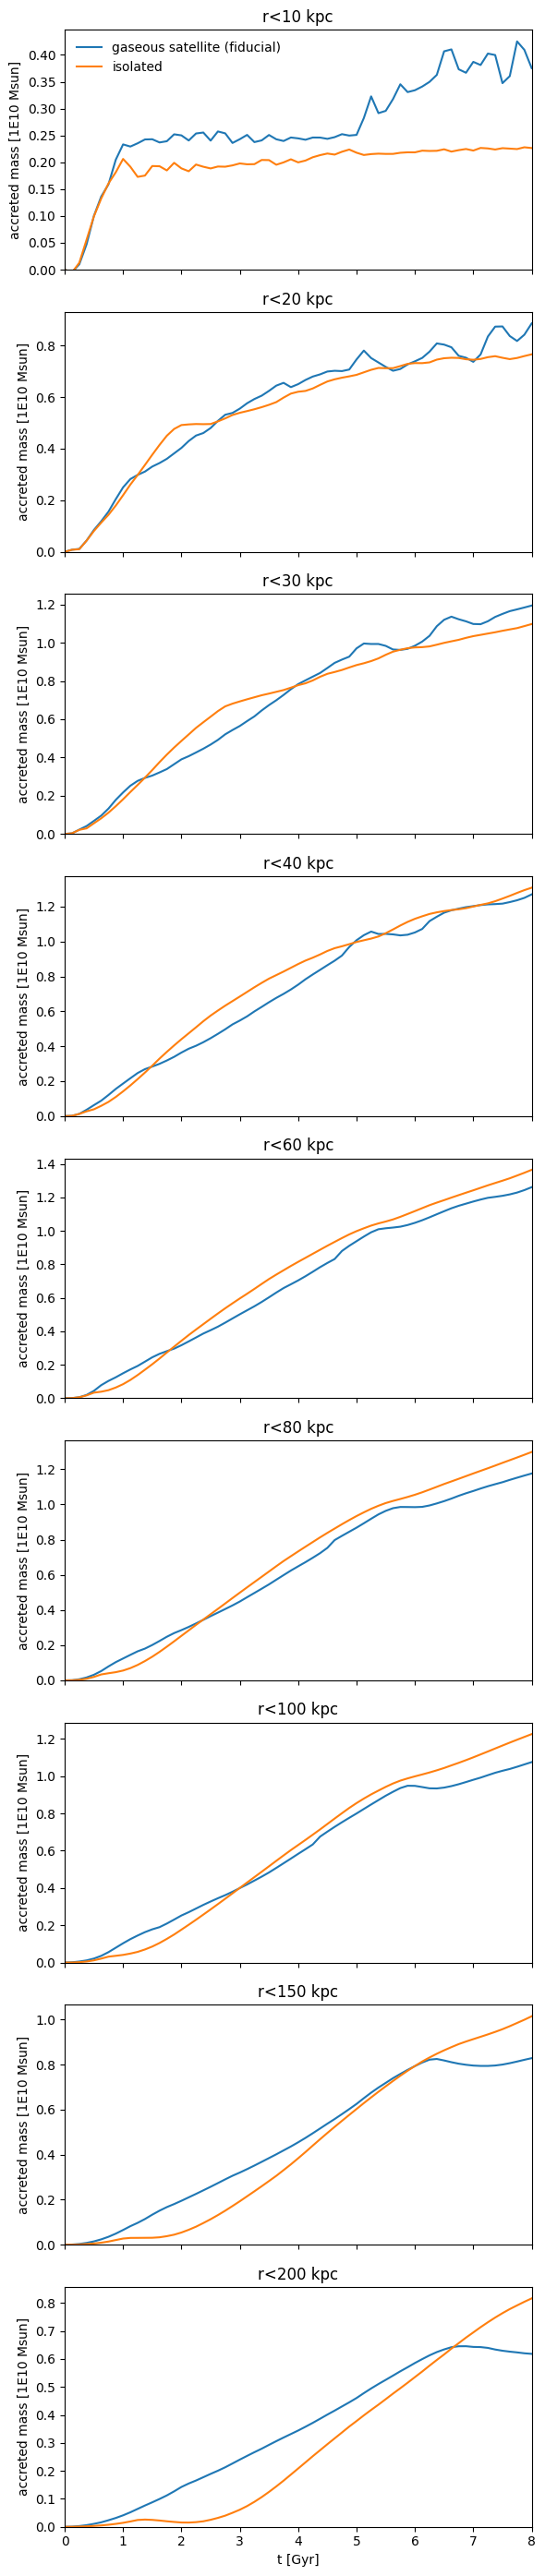

In [86]:
N = len(rcut_list)
fig, axs = plt.subplots(N, 1, figsize=(6, 28), sharex=True)

for i,rcut in enumerate(rcut_list):
    ax = axs[i]

    ax.plot(CumMass[rcut][:,0], CumMass[rcut][:,2] - CumMass[rcut][0,2], label='gaseous satellite (fiducial)')
    ax.plot(CumMass_iso[rcut][:,0], CumMass_iso[rcut][:,2] - CumMass_iso[rcut][0,2], label='isolated')

    ax.set(ylabel='accreted mass [1E10 Msun]', ylim=(0, None), title='r<'+str(rcut)+' kpc')
    
axs[N-1].set(xlabel='t [Gyr]', xlim=(0, 8))

axs[0].legend(frameon=False)

fig.tight_layout()

In [88]:
def get_cum_sf_mass(gal, numscalars=4):
    
    CumSFMass = np.zeros((len(gal['idx_list']), numscalars+1), dtype=float)
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        CumSFMass[i,0] = sn.Time.value
        
        MW_COM = gal['MW_COM'][i]
        pos = sn.part0.pos.value - MW_COM
        r = np.linalg.norm(pos, axis=1)
        
        key = np.logical_and(sn.part0.sfr.value > 0, r<40)
        scalar_mass = sn.part0.PassiveScalars * sn.part0.mass.value.reshape(-1, 1)
        CumSFMass[i,1:] = np.sum(scalar_mass[key], axis=0)

    return CumSFMass

In [89]:
CumSFMass = get_cum_sf_mass(gal)
CumSFMass_iso = get_cum_sf_mass(galiso)

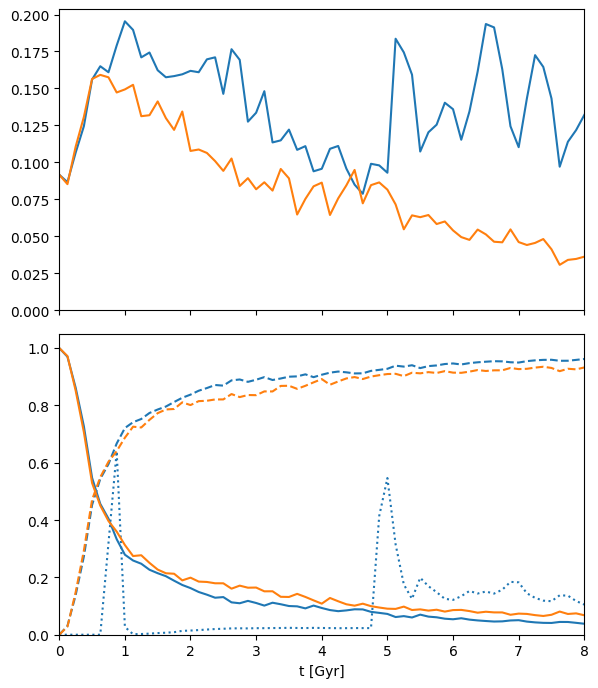

In [90]:
TotSFMass = np.sum(CumSFMass[:,1:3], axis=1)
TotSFMass_iso = np.sum(CumSFMass_iso[:,1:3], axis=1)

TotSFMass = CumSFMass[:,1] + CumSFMass[:,2]
TotSFMass_iso = CumSFMass_iso[:,1] + CumSFMass_iso[:,2]

fig, axs = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

ax = axs[0]
l = ax.plot(CumSFMass[:,0], TotSFMass, label='merger')
liso = ax.plot(CumSFMass_iso[:,0], TotSFMass_iso, label='isolated')
ax.set(ylim=(0, None))

ax = axs[1]
ax.plot(CumSFMass[:,0], CumSFMass[:,1]/TotSFMass, c=l[0].get_color())
ax.plot(CumSFMass[:,0], CumSFMass[:,2]/TotSFMass, c=l[0].get_color(), ls='dashed')
ax.plot(CumSFMass[:,0], (CumSFMass[:,3]+CumSFMass[:,4])/TotSFMass, c=l[0].get_color(), ls='dotted')

ax.plot(CumSFMass_iso[:,0], CumSFMass_iso[:,1]/TotSFMass_iso, c=liso[0].get_color())
ax.plot(CumSFMass_iso[:,0], CumSFMass_iso[:,2]/TotSFMass_iso, c=liso[0].get_color(), ls='dashed')

ax.set(xlim=(0, 8), xlabel='t [Gyr]')
ax.set(ylim=(0, None))

fig.tight_layout()

[(0.0, 1.0)]

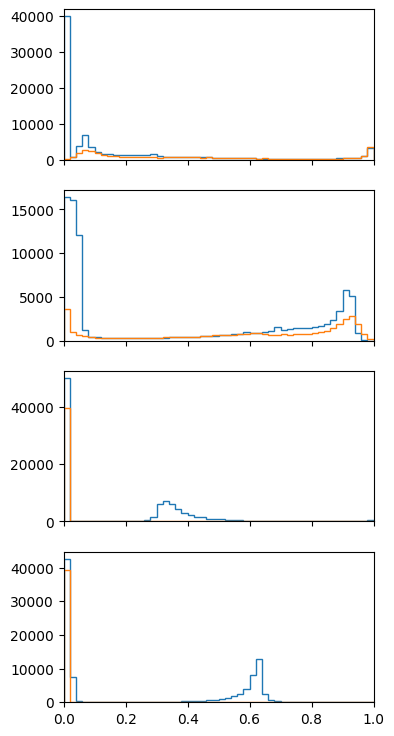

In [19]:
idx = 800

fig, axs = plt.subplots(4, 1, figsize=(4, 9), sharex=True)

for gal_ in [gal, galiso]:
    sn = gal_['sn_idx'][idx]
    is_star = sn.part4.GFM_StellarFormationTime > 0
    i = gal_['i_from_idx'][idx]
    MW_COM = gal_['MW_COM'][i]
    pos = sn.part4.pos.value - MW_COM
    r = np.linalg.norm(pos, axis=1)
    
    # key = np.logical_and(is_star, r < 10)
    key = is_star
    
    for i in range(4):
        ax = axs[i]
        ax.hist(sn.part4.PassiveScalars[key,i], range=(0, 1), bins=50, histtype='step');

axs[0].set(xlim=(0, 1))

# sn = sniso
# is_star = sniso.part4.GFM_StellarFormationTime > 0
# plt.hist(sniso.part4.PassiveScalars[is_star,0], range=(0, 1), bins=50, histtype='step');

In [35]:
def get_cum_coldmass(gal, rmax, rmin=0, logTcut=4.5, numscalars=4):
    
    CumMass = np.zeros((len(gal['idx_list']), numscalars), dtype=float)
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        
        pos = sn.part0.rotpos
        r = np.linalg.norm(pos, axis=1)
        
        _, T = get_n_T(sn)

        rcut = np.logical_and(r > rmin, r < rmax)
        key = np.logical_and(rcut, np.log10(T) < logTcut)
        
        for sc in range(numscalars):
            mass = sn.part0.Masses.value * sn.part0.PassiveScalars[:,sc]
            CumMass[i,sc] = np.sum(mass[key])            

    return CumMass

In [42]:
CumColdMass = get_cum_coldmass(gal, 150, rmin=50)
CumColdMass_iso = get_cum_coldmass(galiso, 150, rmin=50)
CumColdMassN = get_cum_coldmass(galN, 150, rmin=50)
CumColdMass_pro = get_cum_coldmass(galpro, 150, rmin=50)


# CumColdMass50 = get_cum_coldmass(gal, 100, rmin=50)
# CumColdMass_iso50 = get_cum_coldmass(galiso, 100, rmin=50)

In [39]:
pos_sep = gal['GSE_COM'] - gal['MW_COM']
r_sep = np.linalg.norm(pos_sep, axis=1)

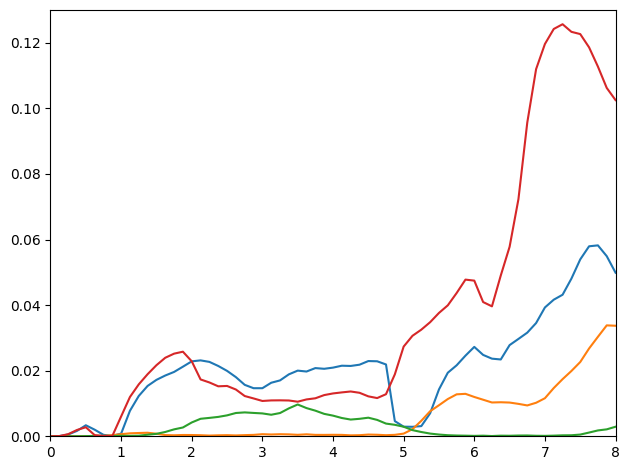

In [52]:
# plt.plot(CumColdMass[:,0], np.sum(CumColdMass[:,1:3], axis=1))
# plt.plot(CumColdMass_iso[:,0], np.sum(CumColdMass_iso[:,1:3], axis=1))

fig, ax = plt.subplots(1, 1)

# ax2 = ax.twinx()
# ax2.plot(gal['Time'], r_sep, c='k', ls='dashed', alpha=0.6)
# ax2.set_ylim(0, None)

l = ax.plot(gal['Time'], CumColdMass[:,1])
# ax.plot(gal['Time'], CumColdMass50[:,1], c=l[0].get_color(), ls='dashed')

l = ax.plot(galiso['Time'], CumColdMass_iso[:,1])
# ax.plot(galiso['Time'], CumColdMass_iso50[:,1], c=l[0].get_color(), ls='dashed')

l = ax.plot(galN['Time'], CumColdMassN[:,1])
l = ax.plot(galpro['Time'], CumColdMass_pro[:,1])

ax.set_ylim(0, 0.13)
ax.set_xlim(0, 8)

fig.tight_layout()

In [95]:
# frac of host CGM turned into stars
def get_cum_coldstar(gal, numscalars=4):
    CumMass = np.zeros((len(gal['idx_list']), numscalars+1), dtype=float)
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        CumMass[i,0] = sn.Time.value
        
        # MW_COM = gal['MW_COM'][idx]
        # pos = sn.part0.pos.value - MW_COM
        # r = np.linalg.norm(pos, axis=1)
        
        # _, T = get_n_T(sn)
        if sn.NumPart_Total[4] == 0:
            continue
        
        is_star = sn.part4.GFM_StellarFormationTime > 0
        key = is_star
        
        for sc in range(numscalars):
            mass = sn.part4.Masses.value * sn.part4.PassiveScalars[:,sc]
            # mass = sn.part4.GFM_InitialMass * sn.part4.PassiveScalars[:,sc]
            CumMass[i,sc+1] = np.sum(mass[key])

    return CumMass

In [96]:
CumColdMass = get_cum_coldstar(gal)
CumColdMass_iso = get_cum_coldstar(galiso)

In [97]:
# fig, axs = plt.subplots(4, 1, figsize=(4, 12), sharex=True, sharey=True)

# for sc in range(4):
#     ax = axs[sc]
#     ax.plot(CumColdMass[:,0], CumColdMass[:,sc+1])
#     ax.plot(CumColdMass_iso[:,0], CumColdMass_iso[:,sc+1])

# axs[3].set(xlabel='t [Gyr]', ylabel='host CGM mass in stars [1E10 Msun]')

# ax.set_xlim(0, 8)
# ax.set_ylim(0, 0.5)

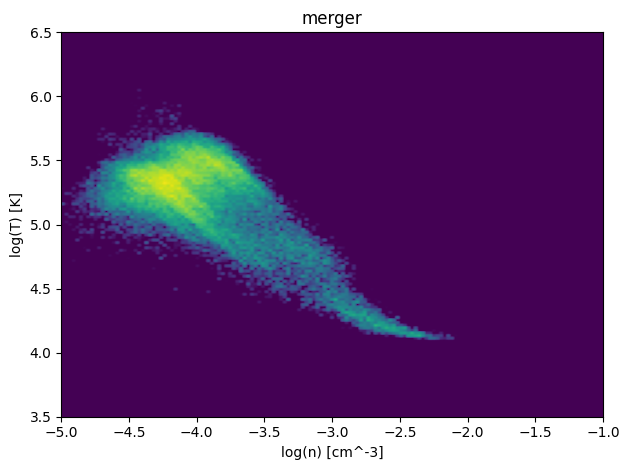

In [98]:
fig, ax = plt.subplots(1, 1)

idx = 800
rmin = 40
rmax = 100
N = 1000
vmin = 1e-5
vmax = 1e-3

i = 0
while gal['idx_list'][i] != idx:
    i += 1
sn = gal['sn_idx'][idx]
n, T = get_n_T(sn)
r = np.linalg.norm(sn.part0.pos - gal['MW_COM'][i], axis=1)
key = np.logical_and(r > rmin, r < rmax)
# key = np.logical_and(key, sn.part0.PassiveScalars[:,1] > 0.2)
# key = np.where(key)[0]
# key = np.random.choice(key, N, replace=False)
mass = sn.part0.PassiveScalars[:,1] * sn.part0.Masses.value

xbins = np.linspace(-5, -1, 150)
ybins = np.linspace(3.5, 6.5, 150)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(np.log10(n[key]), np.log10(T[key]), mass[key],
                                                  statistic='sum', bins=(xbins, ybins))

m_in_bin[m_in_bin < vmin] = vmin

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_aspect('auto')
ax.set(xlabel='log(n) [cm^-3]', ylabel='log(T) [K]')

ax.set_xlim(xbins[0], xbins[-1])
ax.set_ylim(ybins[0], ybins[-1])

ax.set_title('merger')
fig.tight_layout()


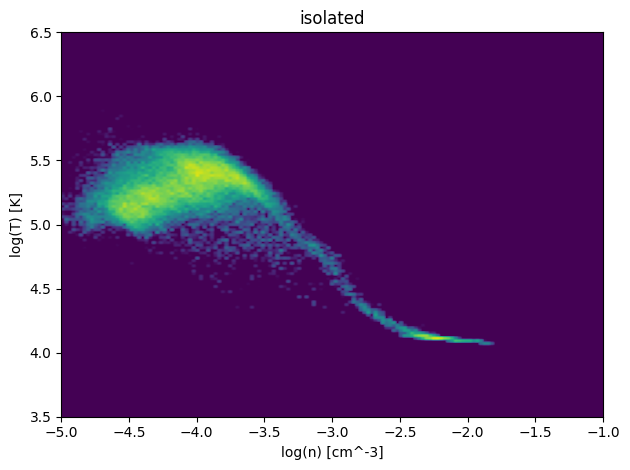

In [29]:
fig, ax = plt.subplots(1, 1)

idx = 800
rmin = 40
rmax = 100
N = 1000
vmin = 1e-5
vmax = 1e-3

i = 0
while galiso['idx_list'][i] != idx:
    i += 1
sn = galiso['sn_idx'][idx]
n, T = get_n_T(sn)
r = np.linalg.norm(sn.part0.pos - galiso['MW_COM'][i], axis=1)
key = np.logical_and(r > rmin, r < rmax)
# key = np.logical_and(key, sn.part0.PassiveScalars[:,1] > 0.2)
# key = np.where(key)[0]
# key = np.random.choice(key, N, replace=False)
mass = sn.part0.PassiveScalars[:,1] * sn.part0.Masses.value

xbins = np.linspace(-5, -1, 150)
ybins = np.linspace(3.5, 6.5, 150)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(np.log10(n[key]), np.log10(T[key]), mass[key],
                                                  statistic='sum', bins=(xbins, ybins))

m_in_bin[m_in_bin < vmin] = vmin

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_aspect('auto')
ax.set(xlabel='log(n) [cm^-3]', ylabel='log(T) [K]')

ax.set_xlim(xbins[0], xbins[-1])
ax.set_ylim(ybins[0], ybins[-1])

ax.set_title('isolated')
fig.tight_layout()


In [99]:
def get_cummass(gal, idx, logTcut=4.5, rmin=40, rmax=100):
    i = gal['i_from_idx'][idx]
    sn = gal['sn_idx'][idx]
    n, T = get_n_T(sn)
    r = np.linalg.norm(sn.part0.pos - gal['MW_COM'][i], axis=1)
    rkey = np.logical_and(r > rmin, r < rmax)
    rTkey = np.logical_and(rkey, np.log10(T) < logTcut)
    
    nmax_list = np.linspace(-5, -1, 100)
    cummass = np.zeros_like(nmax_list)
    mass = sn.part0.PassiveScalars[:,1] * sn.part0.Masses.value
    
    for i,nmax in enumerate(nmax_list):
        key = np.logical_and(rTkey, np.log10(n) < nmax)
        cummass[i] = np.sum(mass[key])
    
    return nmax_list, cummass

In [100]:
idx = 800
nmax, cummass = get_cummass(gal, idx)
nmax_iso, cummass_iso = get_cummass(galiso, idx)

Text(0, 0.5, 'cumulative mass [1E10 Msun]')

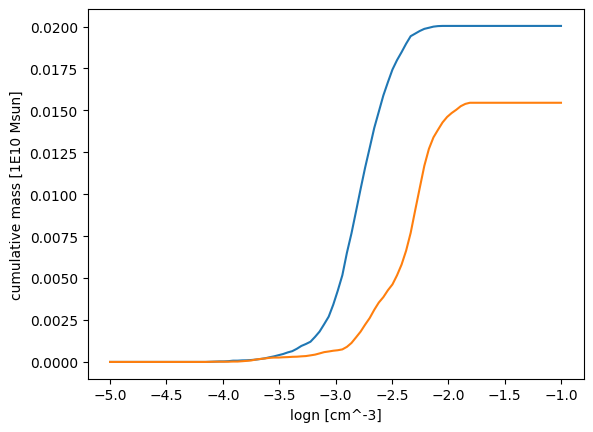

In [101]:
plt.plot(nmax, cummass)
plt.plot(nmax_iso, cummass_iso)
plt.xlabel('logn [cm^-3]')
plt.ylabel('cumulative mass [1E10 Msun]')

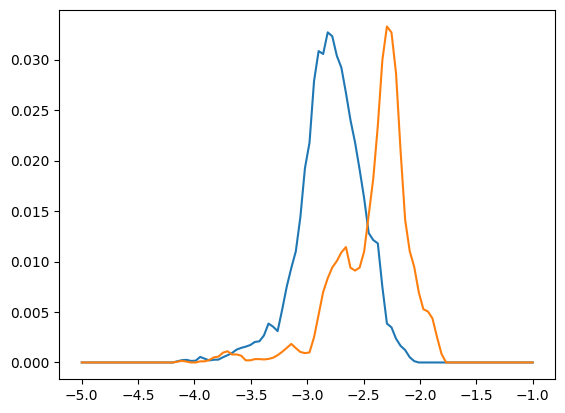

In [102]:
dmdn = np.gradient(cummass, nmax)
dmdn_iso = np.gradient(cummass_iso, nmax_iso)

plt.plot(nmax, dmdn)
plt.plot(nmax_iso, dmdn_iso)

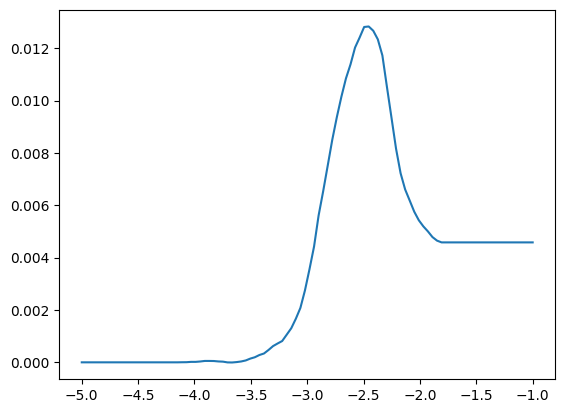

In [35]:
plt.plot(nmax, cummass - cummass_iso)

# Cumulative Stellar Mass

In [64]:
def get_cum_stellar_mass(gal, rcut, numscalars=4):
    
    CumMass = np.zeros((len(gal['idx_list']), numscalars), dtype=float)
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        
        if sn.NumPart_Total[4] == 0:
            continue
        
        MW_COM = gal['MW_COM'][i]
        pos = sn.part4.pos.value - MW_COM
        r = np.linalg.norm(pos, axis=1)
        is_star = sn.part4.GFM_StellarFormationTime > 0
        
        for sc in range(numscalars):
            mass = sn.part4.Masses.value * sn.part4.PassiveScalars[:,sc]
            key = np.logical_and(is_star, r < rcut)
            CumMass[i,sc] = np.sum(mass[key])
            
    return CumMass

In [66]:
CumStarMass = get_cum_stellar_mass(gal, 500)
CumStarMass_iso = get_cum_stellar_mass(galiso, 500)
CumStarMass_isoB = get_cum_stellar_mass(galisoB, 500)
CumStarMassN = get_cum_stellar_mass(galN, 500)
CumStarMass_pro = get_cum_stellar_mass(galpro, 500)
CumStarMassNpro = get_cum_stellar_mass(galNpro, 500)

[Text(0.5, 0, 't [Gyr]'),
 Text(0, 0.5, 'host CGM converted to stars [1E10 Msun]')]

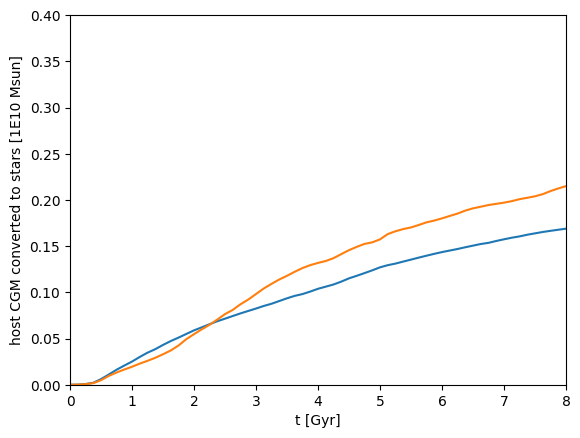

In [67]:
fig, ax = plt.subplots(1, 1)
# ax.plot(gal['Time'], CumStarMass[:,1])
ax.plot(galiso['Time'], CumStarMass_iso[:,1], label='iso (no B)')
# ax.plot(galN['Time'], CumStarMassN[:,1])
# ax.plot(galpro['Time'], CumStarMass_pro[:,1])
# ax.plot(galNpro['Time'], CumStarMassNpro[:,1])
ax.plot(galisoB['Time'], CumStarMass_isoB[:,1], label='iso (w/ B)')

ax.set(xlim=(0, 8), ylim=(0, 0.4))
ax.set(xlabel='t [Gyr]', ylabel='host CGM converted to stars [1E10 Msun]')

# Total angular momentum

In [17]:
def get_tot_angmom(gal, numscalars=4):
    
    TotAngMom = np.zeros((len(gal['idx_list']), 3, numscalars), dtype=float)
    
    # get COM of MW in last snap
    # COM = gal['MW_COM'][-1]
    # COMV = gal['MW_COMV'][-1]
    # BoxSize = gal['sn_idx'][0].BoxSize.value
    # COM = np.array([BoxSize, BoxSize, BoxSize])/2.
    # COMV = np.array([0., 0., 0.])
    
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        
        COM = gal['MW_COM'][i]
        COMV = gal['MW_COMV'][i]
        
        pos = sn.part0.pos.value - COM
        vel = sn.part0.vel.value - COMV
        # pos = sn.part0.rotpos
        # vel = sn.part0.rotvel
        mass = sn.part0.mass.value
        lang = np.cross(pos, vel)
        
        for sc in range(numscalars):
            scmass = mass * sn.part0.PassiveScalars[:,sc]
            TotAngMom[i,:,sc] = np.sum(lang * scmass.reshape(-1, 1))
        
        if sn.NumPart_Total[4] > 0:
            continue
            pos = sn.part4.rotpos
            vel = sn.part4.rotvel
            mass = sn.part4.mass.value
            lang = np.cross(pos, vel)
        
            for sc in range(numscalars):
                scmass = mass * sn.part4.PassiveScalars[:,sc]
                TotAngMom[i,:,sc] += np.sum(lang * scmass.reshape(-1, 1))
        
    return TotAngMom

In [23]:
TotAngMom = np.linalg.norm(get_tot_angmom(gal), axis=1)
TotAngMomiso = np.linalg.norm(get_tot_angmom(galiso), axis=1)
TotAngMom_pro = np.linalg.norm(get_tot_angmom(galpro), axis=1)
TotAngMomN = np.linalg.norm(get_tot_angmom(galN), axis=1)

In [21]:
TotAngMom.shape

(65, 4)

(0.0, 8.0)

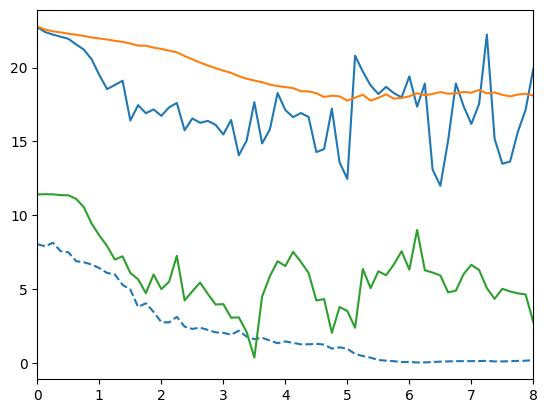

In [25]:
l = plt.plot(gal['Time'], TotAngMom[:,1]/1e3)
plt.plot(gal['Time'], (TotAngMom[:,2] + TotAngMom[:,3])/1e3, c=l[0].get_color(), ls='dashed')

plt.plot(galiso['Time'], TotAngMomiso[:,1]/1e3)

# l = plt.plot(galN['Time'], TotAngMomN[:,1]/1e3)
# plt.plot(galN['Time'], (TotAngMomN[:,2] + TotAngMomN[:,3])/1e3, c=l[0].get_color(), ls='dashed')

plt.xlim(0, 8)
# plt.ylim(0, None)

In [112]:
def get_mean_angmom(gal, numscalars=4):
    
    TotAngMom = np.zeros((len(gal['idx_list']), 3, numscalars), dtype=float)
    
    # get COM of MW in last snap
    # COM = gal['MW_COM'][-1]
    # COMV = gal['MW_COMV'][-1]
    # BoxSize = gal['sn_idx'][0].BoxSize.value
    # COM = np.array([BoxSize, BoxSize, BoxSize])/2.
    # COMV = np.array([0., 0., 0.])
    
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        
        # COM = gal['MW_COM'][i]
        # COMV = gal['MW_COMV'][i]
        
        # pos = sn.part0.pos.value - COM
        # vel = sn.part0.vel.value - COMV
        pos = sn.part0.rotpos
        vel = sn.part0.rotvel
        mass = sn.part0.mass.value
        lang = np.cross(pos, vel)
        
        for sc in range(numscalars):
            scmass = mass * sn.part0.PassiveScalars[:,sc]
            TotAngMom[i,:,sc] = np.sum(lang * scmass.reshape(-1, 1)) / np.sum(scmass)
        
        if sn.NumPart_Total[4] > 0:
            pos = sn.part4.rotpos
            vel = sn.part4.rotvel
            mass = sn.part4.mass.value
            lang = np.cross(pos, vel)
        
            for sc in range(numscalars):
                scmass = mass * sn.part4.PassiveScalars[:,sc]
                TotAngMom[i,:,sc] += np.sum(lang * scmass.reshape(-1, 1)) / np.sum(scmass)
        
    return TotAngMom

In [113]:
MeanAngMom = get_mean_angmom(gal)
MeanAngMomiso = get_mean_angmom(galiso)

/tmp/ipykernel_2500837/500194133.py:27: RuntimeWarning: invalid value encountered in scalar divide
  TotAngMom[i,:,sc] = np.sum(lang * scmass.reshape(-1, 1)) / np.sum(scmass)
/tmp/ipykernel_2500837/500194133.py:37: RuntimeWarning: invalid value encountered in scalar divide
  TotAngMom[i,:,sc] += np.sum(lang * scmass.reshape(-1, 1)) / np.sum(scmass)


(0.0, 8.0)

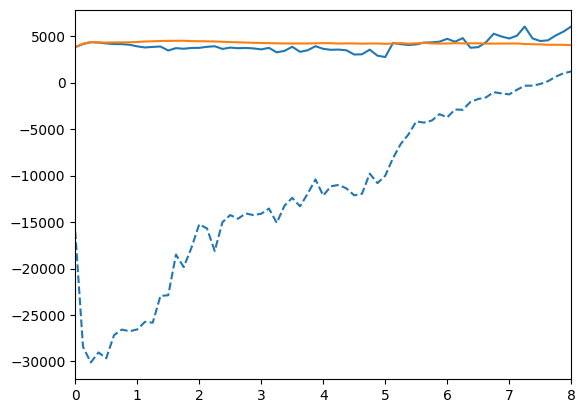

In [114]:
l = plt.plot(gal['Time'], MeanAngMom[:,2,1])
plt.plot(gal['Time'], MeanAngMom[:,2,2] + TotAngMom[:,2,3], c=l[0].get_color(), ls='dashed')

plt.plot(galiso['Time'], MeanAngMomiso[:,2,1])

plt.xlim(0, 8)
# plt.ylim(0, None)

# Star Formation Rate

In [125]:
def get_sfr(gal, rMW_cut=30, rMW_min=1, rGSE_cut=20):
    
    SFR = np.zeros((len(gal['idx_list']), 3), dtype=float)
    
    for i,idx in enumerate(gal['idx_list']):
        sn = gal['sn_idx'][idx]
        
        MW_COM = gal['MW_COM'][i]        
        rMW = np.linalg.norm(sn.part0.pos.value - MW_COM, axis=1)
        in_MW = np.logical_and(rMW < rMW_cut, rMW > rMW_min)
        
        if len(gal['GSE_COM']) > 0:
            GSE_COM = gal['GSE_COM'][i]
            rGSE = np.linalg.norm(sn.part0.pos.value - GSE_COM, axis=1)
            in_GSE = np.logical_and(np.logical_not(in_MW), rGSE < rGSE_cut)
        else:
            in_GSE = np.full_like(in_MW, False)
        
        in_neither = np.logical_not(np.logical_or(in_MW, in_GSE))
        
        sfr_scalar = sn.part0.sfr*sn.part0.PassiveScalars[:,1]
        
        SFR[i,0] = np.sum(sfr_scalar[in_MW])
        SFR[i,1] = np.sum(sfr_scalar[in_GSE])
        SFR[i,2] = np.sum(sfr_scalar[in_neither])
        
        # print(i, idx, np.sum(sn.part0.sfr), SFR[i,0] + SFR[i,1] + SFR[i,2])
        # assert np.sum(sn.part0.sfr) == SFR[i,0] + SFR[i,1] + SFR[i,2]
        
    return SFR

In [126]:
TotSFR = get_sfr(gal)
TotSFRiso = get_sfr(galiso)

(0.0, 1.4736715793609618)

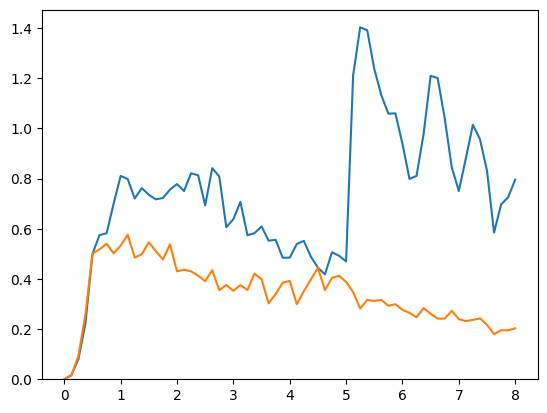

In [127]:
plt.plot(gal['Time'], np.sum(TotSFR, axis=1))
plt.plot(galiso['Time'], np.sum(TotSFRiso, axis=1))
plt.ylim(0, None)

(0.0, 8.0)

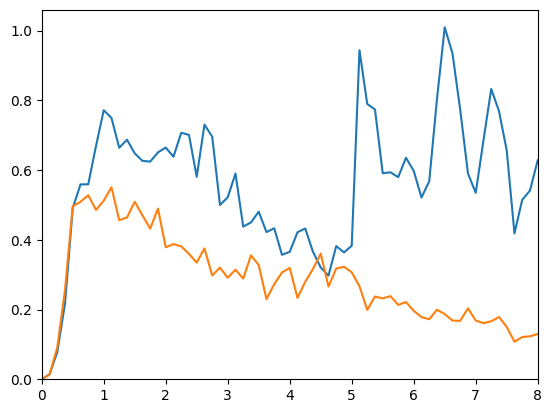

In [128]:
plt.plot(gal['Time'], TotSFR[:,0])
plt.plot(galiso['Time'], TotSFRiso[:,0])
plt.ylim(0, None)
plt.xlim(0, 8)

# metallicity

In [46]:
idx = gal['idx_list'][-1]
sn = gal['sn_idx'][idx]

(0.0, 0.1)


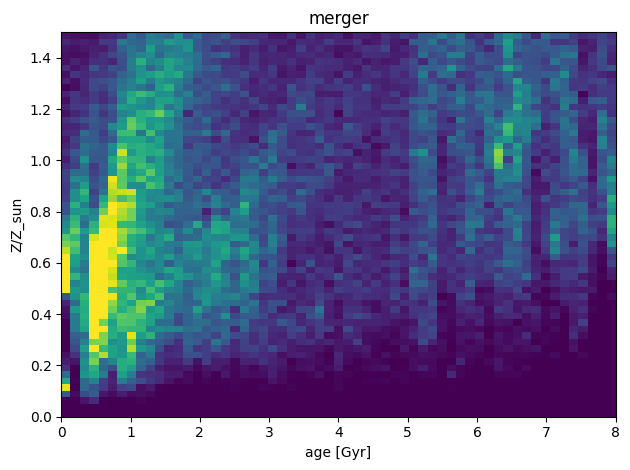

In [129]:
fig, ax = plt.subplots(1, 1)

idx = 1600
rmin = 40
rmax = 100
N = 1000
vmin = 0
vmax = 0.1

i = gal['i_from_idx'][idx]
sn = gal['sn_idx'][idx]

pos = sn.part4.rotpos
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]
key = np.logical_and(R < 15, np.abs(z) < 3)

Z = sn.part4.GFM_Metallicity/0.0127
age = sn.part4.GFM_StellarFormationTime
mass = sn.part4.Masses.value

xbins = np.linspace(0, 8, 60)
ybins = np.linspace(0, 1.5, 60)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(age[key], Z[key], mass[key],
                                                  statistic='sum', bins=(xbins, ybins))

# m_in_bin[m_in_bin < vmin] = vmin
m_in_bin /= dx*dy

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, 
               vmin=vmin, vmax=vmax)#, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_aspect('auto')
ax.set(xlabel='age [Gyr]', ylabel='Z/Z_sun')

ax.set_xlim(xbins[0], xbins[-1])
ax.set_ylim(ybins[0], ybins[-1])

print(im.get_clim())

ax.set_title('merger')
fig.tight_layout()


(0.0, 0.1)


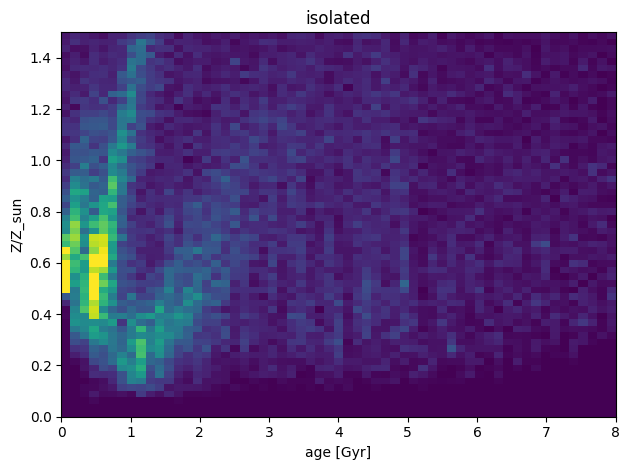

In [130]:
fig, ax = plt.subplots(1, 1)

idx = 1600
rmin = 40
rmax = 100
N = 1000
vmin = 0
vmax = 0.1

i = galiso['i_from_idx'][idx]
sn = galiso['sn_idx'][idx]

pos = sn.part4.rotpos
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]
key = np.logical_and(R < 15, np.abs(z) < 3)

Z = sn.part4.GFM_Metallicity/0.0127
age = sn.part4.GFM_StellarFormationTime
mass = sn.part4.Masses.value

xbins = np.linspace(0, 8, 60)
ybins = np.linspace(0, 1.5, 60)
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

dx = (xbins[-1]-xbins[0])/len(xbins)
dy = (ybins[-1]-ybins[0])/len(ybins)

m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(age[key], Z[key], mass[key],
                                                  statistic='sum', bins=(xbins, ybins))

# m_in_bin[m_in_bin < vmin] = vmin
m_in_bin /= dx*dy

im = ax.imshow(m_in_bin.T, origin='lower', extent=extent, 
               vmin=vmin, vmax=vmax)#, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_aspect('auto')
ax.set(xlabel='age [Gyr]', ylabel='Z/Z_sun')

ax.set_xlim(xbins[0], xbins[-1])
ax.set_ylim(ybins[0], ybins[-1])

print(im.get_clim())

ax.set_title('isolated')
fig.tight_layout()


In [131]:
def get_mean_Z(gal):
    dT = 0.5
    T = 0

    idx = gal['idx_list'][-1]
    i = gal['i_from_idx'][idx]
    sn = gal['sn_idx'][idx]
    
    age = sn.part4.GFM_StellarFormationTime
    Z = sn.part4.GFM_Metallicity/0.0127
    
    ave_age = []
    ave_Z = []
    
    while T < 8:
        key = np.logical_and(age > T, age < T + dT)
        ave_age.append(np.mean(age[key]))
        ave_Z.append(np.mean(Z[key]))
        T += dT
    
    return np.array(ave_age), np.array(ave_Z)

In [132]:
age, Z = get_mean_Z(gal)
ageiso, Ziso = get_mean_Z(galiso)

(0.0, 3.7441627591848374)

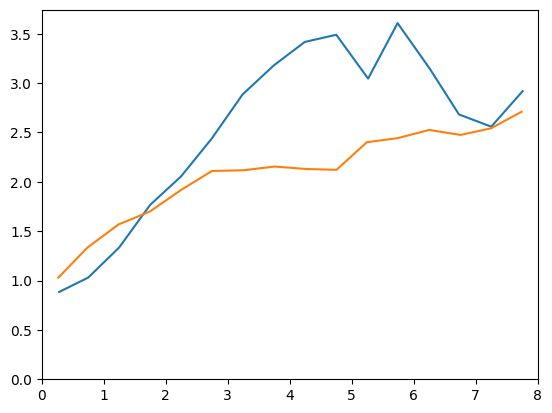

In [133]:
plt.plot(age, Z)
plt.plot(ageiso, Ziso)

plt.xlim(0, 8)
plt.ylim(0, None)

# Cooling time

In [145]:
def get_cooling_time(sn):
    UnitMass_in_g = sn.parameters.UnitMass_in_g
    UnitLength_in_cm = sn.parameters.UnitLength_in_cm
    UnitVelocity_in_cm_per_s = sn.parameters.UnitVelocity_in_cm_per_s
    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitPressure_in_cgs = UnitMass_in_g / UnitLength_in_cm / (UnitTime_in_s**2)
    UnitDensity_in_cgs = UnitMass_in_g / (UnitLength_in_cm)**3
    UnitEnergy_in_cgs = UnitMass_in_g * (UnitLength_in_cm/UnitTime_in_s)**2
    
    n, T = get_n_T(sn)
    
    Lambda = - sn.part0.GFM_CoolingRate.value
    C = n**2 * Lambda # in units of erg/s/cm^3
    C /= UnitEnergy_in_cgs / UnitTime_in_s / (UnitLength_in_cm)**3
    energy = sn.part0.rho.value * sn.part0.u.value

    tcool = energy/C
    
    return tcool

21.08434028625489


/tmp/ipykernel_2500837/4268172486.py:18: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(tcool[key]), range=(-6, 4), bins=100, histtype='step', weights=scmass[key]);
/tmp/ipykernel_2500837/4268172486.py:19: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(tcooliso[keyiso]), range=(-6, 4), bins=100, histtype='step', weights=scmass_iso[keyiso]);


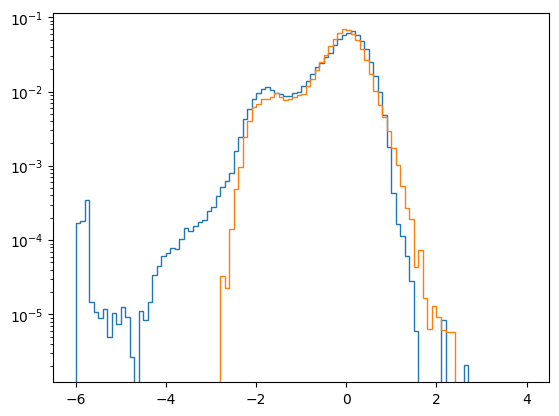

In [159]:
idx = 1200

sn = gal['sn_idx'][idx]
tcool = get_cooling_time(sn)
r = np.linalg.norm(sn.part0.rotpos, axis=1)
key = np.logical_and(r > 40, r < 150)

sniso = galiso['sn_idx'][idx]
tcooliso = get_cooling_time(sniso)
riso = np.linalg.norm(sniso.part0.rotpos, axis=1)
keyiso = np.logical_and(riso > 40, riso < 150)

print(np.percentile(tcool, 90))

scmass = sn.part0.PassiveScalars[:,1] * sn.part0.mass.value
scmass_iso = sniso.part0.PassiveScalars[:,1] * sniso.part0.mass.value

plt.hist(np.log10(tcool[key]), range=(-6, 4), bins=100, histtype='step', weights=scmass[key]);
plt.hist(np.log10(tcooliso[keyiso]), range=(-6, 4), bins=100, histtype='step', weights=scmass_iso[keyiso]);
plt.yscale('log')

In [34]:
print(gal['MW_COMV'][0])
print(gal['GSE_COMV'][0])
gal['GSE_COM'][0] - gal['MW_COM'][0]

r = gal['GSE_COM'][0] - gal['MW_COM'][0]
v = gal['GSE_COMV'][0] - gal['MW_COMV'][0]
np.cross(r, v)

[-8.988282  -2.349236  -3.6118515]
[ 95.923195  47.109734 -73.41543 ]


array([-1648.46597154, -5196.82207271, -6159.74854299])